In [1]:
# Show entire workflow for a new molecule
import yaml, re, sys, os, glob
import pandas as pd
import numpy as np

sys.path.insert(0, '../atomic_SOC')
import molpro_subs as mpr
import chem_subs as chem
sys.path.insert(0, '../karlib')
import gaussian_subs as gau
import multirx_subs as mrx

In [2]:
# sub-directory names
GDIR = mrx.GDIR    # Gaussian files, geom opt and harmonic freqs
EDIR = mrx.EDIR    # Molpro files, single-point CCSD(T)-F12
REFD = mrx.REFDAT     # Reference data
DATA = mrx.MDAT  # Processed molecular YAML files
JUNK = 'discard/energysp'  # CC outputs rejected because of old filename format

In [3]:
# Import reference data
atct, webbook, soc, dflabel, reflocal, dfeleca, dfelecm, override = mrx.generate_molec_yaml()

In [4]:
# check names list for duplicates
dup1 = dflabel.duplicated(subset='Label', keep=False)
dup2 = dflabel.duplicated(subset='Name', keep=False)
if dup1.any() or dup2.any():
    print('** Duplication in label_meanings.tsv **')
    if dup1.any():
        print('>>> dup1 =', dup1)
        print(dflabel[dup1])
    if dup2.any():
        print(dflabel[dup2])

In [5]:
molec = input('Molecular label to use in filenames: ')
descr = input('Descriptive name of molecule: ')
CASRN = input('CASRN: ').strip()

Molecular label to use in filenames: Bz2
Descriptive name of molecule: 
CASRN: 


In [6]:
subdf = dflabel[dflabel.CASRN == CASRN]
if CASRN in dflabel.CASRN.tolist():
    # CAS number is highest reliability
    print('CASRN matched')
elif descr in dflabel.Name.tolist():
    # next is molecule name
    print('Name matched')
    subdf = dflabel[dflabel.Name == descr]
elif molec in dflabel.Label.tolist():
    # abbreviated label is least reliable
    print('Label matched')
    subdf = dflabel[dflabel.Label == molec]

Label matched


In [7]:
if len(subdf):
    print('That molecule is already in the list.')
    newmol = False
    display(subdf)
    if len(subdf) > 1:
        chem.print_err('', f'More than one molecule matched: problem in {flabel}')
    else:
        [molec, descr, CASRN, cCAS] = subdf.iloc[0].tolist()
        print(f'Using label = {molec}, descriptive name = {descr}, CASRN = {CASRN}')
else:
    print('That molecule is not in the list')
    newmol = True
    rewrite = input('Add it to the list (y/n)? ').strip()
    rewrite = ('y' == rewrite.lower()[0])
    if rewrite:
        if CASRN:
            print(f'Adding {molec} to {flabel} as "{descr}" with CASRN = {CASRN}')
            dflabel.loc[len(dflabel)] = [molec, descr, CASRN]
            dflabel.to_csv(flabel, sep='\t', index=False)
            print(f'Glossary file {flabel} updated')
        else:
            chem.print_err('', 'I need a CASRN.  Try again.')

That molecule is already in the list.


,Label,Name,CASRN,cCAS
405,Bz2,"1,2-diphenylethane",103-29-7,103297


Using label = Bz2, descriptive name = 1,2-diphenylethane, CASRN = 103-29-7


In [8]:
# Write a new gjf file?     
writegjf = newmol
fgjf = os.sep.join([GDIR, f'{molec}.gjf'])
if os.path.isfile(fgjf):
    confirm = input('Overwrite existing Gaussian input (.gjf) file [y/n]? ')
    writegjf = (len(confirm) > 0) and (confirm[0] in 'yY')
if writegjf:
    charge = 0  # no ions in DB
    spinmult = input('Spin multiplicity (singlet = 1): ')
    fout = fgjf.replace('gjf', 'out')
    if os.path.isfile(fout):
        reuse = input('Use coordinates from existing Gaussian output file [y/n]? ')
        if reuse[0] in 'yY':
            # Get coords from fout
            with open(fout, 'r') as F:
                dfcoord = gau.read_std_orient(F)
                coords = dfcoord.Coordinates.iloc[-1].values
        else:
            # Manual input of coordinates
            # Input newlines apparently not preserved
            eof = ''
            print('Paste coordinates here (element, x, y, z):')
            coordtxt = input()
            # Parse coordtxt
            words = coordtxt.strip().split()
            nw = len(words)
            if nw % 4 != 0:
                chem.print_err('', 'Cannot parse coordinates; number of fields is not a multiple of 4')
            natom = nw // 4
            coords = []  # list of lists
            for iat in range(natom):
                j = iat * 4
                el = chem.elz(words[j], 'symbol')
                [x, y, z] = [float(words[j+k]) for k in [1, 2, 3]]
                coords.append([el, x, y, z])
    print('Note:  Any symmetry elements must be reflected in the input coordinates')
    mrx.write_GJF(molec, descr, spinmult, coords, nproc=8)

Overwrite existing Gaussian input (.gjf) file [y/n]? n


## Run the Gaussian calculation and then return here

In [9]:
fgau = os.sep.join([GDIR, f'{molec}.out'])

In [10]:
fin = os.sep.join([EDIR, f'{molec}.in'])
if os.path.isfile(fin):
    confirm = input('Overwrite existing Molpro input (.in) file [y/n]? ')
    writein = (len(confirm) > 0) and (confirm[0] in 'yY')
else:
    # no existing file
    writein = True
if writein:
    mrx.make_f12_input(fgau, EDIR)

Overwrite existing Molpro input (.in) file [y/n]? n


## Run the Molpro calculation and then return here

In [11]:
useCIR = False  # flag to use flaky CIRconvert calls

In [12]:
# Create the molecular data file
mdoc = mrx.generate_molec_yaml(molec, atct, webbook, soc, dflabel, reflocal, dfeleca, dfelecm, override,
                               use_CIR=useCIR, verbose=True)

--- Preparing data file for Bz2 ---
CASRN = 103-29-7
Local name = 1,2-diphenylethane
Molpro and Gaussian nuclear repulsion energies are consistent
Molpro and Gaussian (RO)HF energies are consistent
Hill:    C14H14
ATcT data (DataFrame):


,Species,Formula,EoF0,EoF298,Unc,MW,ATcT_ID,Hill,cCAS
1009,"1,2-Diphenylethane",C6H5CH2CH2C6H5,180.560000,142.070000,0.760000,182.261000,103-29-7*0,C14H14,103297


WebBook data:
- CASRN: 103-29-7
  WB_ID: C103297
  formula: C14H14
  name_favored: Bibenzyl
  names:
  - Bibenzyl
  - Benzene, 1,1'-(1,2-ethanediyl)bis-
  - s-Diphenylethane
  - Dibenzil
  - Dibenzyl
  - Ethane, 1,2-diphenyl-
  - 1,2-Diphenylethane
  - Benzene, (phenylethyl)-
  - 1,2-Diphenylethane(sym)
  - 1,2-Diphenylethane, s
  - sym-Diphenylethane
  - Dihydrostilbene
  - NSC 30686
  thermo:
  - EoF298: 135.603
    comment: method:Ccb
    k_cover: 2.0
    squib: 1966COL/PIL821-827
    unc: 1.297
    unit: kJ/mol
  - EoF298: 129.0
    comment: '# Value computed using «Delta»_fH_s_o_l_i_d° value of 44.9±3.1kj/mol
      from 1946PAR/WES2524-2527 and «Delta»_s_u_bH° value of 84.1kj/mol from 1966COL/PIL821-827.'
    k_cover: 2.0
    squib: 1946PAR/WES2524-2527
    unc: -1
    unit: kJ/mol

WebBook has 2 values for EoF298
  Discarding EoF298 = 129.0 because no uncertainty (squib 1946PAR/WES2524-2527)
Functional groups detected:
    benzene ring    [(0, 4, 7, 11, 8, 6), (9, 2, 1, 5, 3, 10)

In [13]:
# save molecular data to YAML file
fout = mrx.write_molec_yaml(molec, mdoc, verbose=True)

YAML file created:  molec_data\Bz2.yml


In [14]:
# Read it back and display, to be sure it didn't have trouble with any dtypes
ydat = mrx.read_molec_yaml(molec)
ydat

{'Charge': 0,
 'Electronic': {},
 'Energy': {'CCSD(T)-F12b': -541.110661832101,
  'CCSD-F12b': -540.982926877244,
  'HF': -538.523830370484,
  'Nuclear_repulsion': 800.26289604,
  'basis': 'CC-PVTZ-F12',
  'basis_functions': 994,
  'nirreps': 2,
  'point_group': 'C2',
  'software': 'Molpro Version 2023.2',
  'state': '1A'},
 'Frequencies': [27.661,
  29.1422,
  40.11,
  121.9023,
  122.6876,
  224.9807,
  332.0424,
  362.0618,
  368.7606,
  416.8996,
  417.0942,
  484.9255,
  514.8706,
  549.9456,
  590.807,
  638.3067,
  638.9343,
  717.4752,
  718.767,
  755.2389,
  770.776,
  783.0475,
  784.728,
  861.2205,
  861.9356,
  910.3043,
  929.1497,
  946.3223,
  965.1029,
  993.8858,
  994.0299,
  1008.8807,
  1011.8799,
  1014.2448,
  1022.564,
  1022.8219,
  1052.8511,
  1053.8073,
  1095.3078,
  1111.1949,
  1169.3572,
  1182.8811,
  1183.5909,
  1205.4899,
  1205.8831,
  1212.8548,
  1221.4245,
  1244.968,
  1324.1601,
  1338.1838,
  1348.6321,
  1366.538,
  1373.5768,
  1376.032,
  

## Generate working reactions

In [15]:
# Process all available molecular YAML files
moldata, Gdict = mrx.read_all_molec_yamls()

Reading 456 molecular YAML files
*** Warning: "No SOC data for open-shell linear molecule ncn" in compute_E0()
*** Warning: "No SOC data for open-shell linear molecule nco" in compute_E0()
*** Warning: "No SOC data for open-shell linear molecule nh" in compute_E0()
*** Warning: "No SOC data for open-shell linear molecule o2" in compute_E0()
*** Warning: "No SOC data for open-shell linear molecule s2" in compute_E0()
*** Warning: "No SOC data for open-shell linear molecule so" in compute_E0()


In [16]:
# Get the name codes
dfnames = dflabel

In [17]:
# Assume that the target molecule is the one we just calculated 
target = molec
print(f'Target = {target}')

Target = Bz2


In [18]:
myml = mrx.read_molec_yaml(molec)

In [19]:
rxns = mrx.generate_reactions(target, moldata, Gdict, Benson=False, verbose=False)

In [20]:
dfrx, fmtrx = mrx.build_reactions_DF(rxns, moldata, target, verbose=True)
print(f'Accepted {len(dfrx)} of {len(rxns)} reactions')
display(dfrx.style.format(fmtrx))

*** Warning: "No exptl data for butene2" in select_expt()
*** Warning: "No exptl data for c2h3nh2" in select_expt()
*** Warning: "No exptl data for c2h4nh" in select_expt()
*** Warning: "No exptl data for ch2nch2" in select_expt()
*** Warning: "No exptl data for ch2ohoh" in select_expt()
*** Warning: "No exptl data for ch3cchch2ch2" in select_expt()
*** Warning: "No exptl data for ch3chnh" in select_expt()
*** Warning: "No exptl data for ch3coch2oh" in select_expt()
*** Warning: "No exptl data for ch3cocooh" in select_expt()
*** Warning: "No exptl data for ch3nch2" in select_expt()
*** Warning: "No exptl data for chclchcl" in select_expt()
*** Warning: "No exptl data for chfchf" in select_expt()
*** Warning: "No exptl data for cyc5dime11" in select_expt()
*** Warning: "No exptl data for cyc7diene" in select_expt()
*** Warning: "No exptl data for cyrene" in select_expt()
*** Warning: "No exptl data for fluorene" in select_expt()
*** Warning: "No exptl data for h2so3" in select_expt()
**

,EoF,dH(rxn),uexp,Reaction,rho_E,rho_T,rho_c
0,188.2,-626.0,0.8,Bz2 + 16 ch4 = 9 c2h6 + 6 c2h4,626.0,34.0,89.1
1,205.7,-478.9,1.1,Bz2 + 14 h2o + 7 h2 = 14 ch3oh,478.9,66.8,236.4
2,202.6,-430.4,1.6,Bz2 + 14 hf + 7 h2 = 14 ch3f,430.4,75.6,354.5
3,191.8,-55.7,1.8,Bz2 + 14 hcl + 7 h2 = 14 ch3cl,55.7,43.7,119.2
4,181.7,1113.5,0.3,Bz2 + 21 h2 = 14 ch4,1113.5,93.9,267.1
5,184.6,7360.7,0.1,Bz2 + 35/2 o2 = 14 co2 + 7 h2o,7360.7,22.9,239.5
6,262.8,-9696.8,0.3,Bz2 = 14 c + 7 h2,9701.7,249.6,2377.4
7,179.8,-55.0,0.3,Bz2 = 7/3 benzene,55.0,4.5,51.9
8,177.1,-119.8,0.5,Bz2 = 7/4 styrene,119.8,2.0,32.8
9,179.6,-361.5,1.3,Bz2 = 7/3 fulvene,361.5,3.8,29.6


## Nonuniform weighting

In [21]:
# choose unreliability measure and temperature
rho = 'rho_E'
# I don't know if it works for T != 0
T = 0

print(f'Target = {target}')
print(f'Non-uniform weighting using {rho}:')
wmean, semw, rwmsx, a, b, change, niter = mrx.nonuniform_weighting(target, rho, dfrx,
                                                        verbose=False)
# combine SEMw with u_exp
print('\tSEMw = {:.1f}, uexp = {:.1f} kJ/mol'.format(semw, rwmsx))
unc = np.sqrt(semw**2 + rwmsx**2)  # 'rwmsx' from eq. (13)
print('\tEoF({:.1f} K) = ({:.1f} ± {:.1f}) kJ/mol (standard uncertainty)'.format(T, wmean, unc))
try:
    expt = exptl[target]
    uc = np.sqrt(unc**2 + expt['unc']**2)  # for comparing with expt
    zs = (wmean - expt['EoF']) / uc
    print('Experimental value = ({:.1f} ± {:.1f}); Z-score = {:.1f}'.format(expt['EoF'], expt['unc'], zs))
except:
    print('No experimental value available')

Target = Bz2
Non-uniform weighting using rho_E:
	SEMw = 1.1, uexp = 1.2 kJ/mol
	EoF(0.0 K) = (179.2 ± 1.6) kJ/mol (standard uncertainty)
No experimental value available


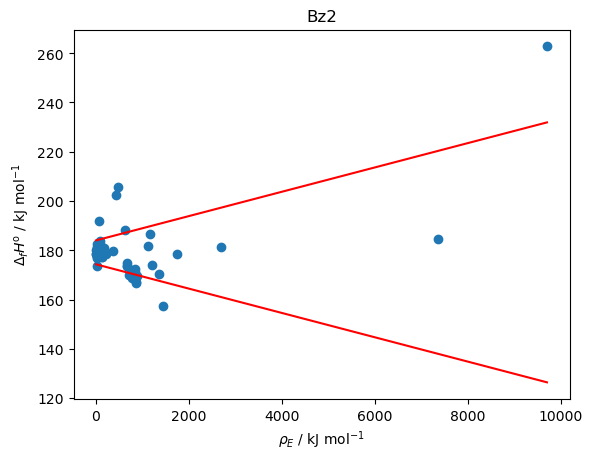

In [22]:
mrx.plot_with_wedge(dfrx, target, rho, wmean, a, b)

## Probabilistic weighting

In [23]:
print('Probabilistic weighting:')
parms, bstrap = mrx.probabilistic_weighting(target, rho, [wmean, a, b], dfrx, verbose=False)
[H, sigma0, beta] = parms
[stdH, Hvals, ttime] = bstrap
print('\tEoF = ({:.1f} ± {:.1f}) kJ/mol (standard uncertainty)'.format(H, stdH))
print('\tParameter bootstrapping took {:.0f} s to compute {:d} values for H\''.format(ttime, len(Hvals)))

Probabilistic weighting:
	EoF = (180.1 ± 0.7) kJ/mol (standard uncertainty)
	Parameter bootstrapping took 30 s to compute 737 values for H'


## Below is to apply all six combinations of (3 rho values) * (2 data analysis methods)

In [24]:
# This takes a few minutes
df3, fmt = mrx.table3(target, dfrx)

In [25]:
display(df3.style.format(fmt))

,$\rho$ choice,weighting,$a$ or ${\sigma}_0$,$b$ or $\beta$,$H$,$u$($H$)
0,rho_T,nonuniform,2.67,0.2827,177.9,1.4
1,rho_T,probabilistic,3.37,0.3626,177.7,0.7
2,rho_c,nonuniform,4.90,0.0330,178.1,1.6
3,rho_c,probabilistic,1.72,0.0945,178.6,0.5
4,rho_E,nonuniform,4.86,0.0049,179.2,1.6
5,rho_E,probabilistic,3.17,0.0151,180.1,0.7


In [26]:
# Compare with experimental value (if available)
exptl = mrx.select_expt(moldata, T, verbose=False)
mrx.compare_refdata(target, exptl, df3, fmt, verbose=False)
display(df3.style.format(fmt))

,$\rho$ choice,weighting,$a$ or ${\sigma}_0$,$b$ or $\beta$,$H$,$u$($H$),$u_c$,error,Z-score
0,rho_T,nonuniform,2.67,0.2827,177.9,1.4,1.5,-2.7,-1.8
1,rho_T,probabilistic,3.37,0.3626,177.7,0.7,0.8,-2.8,-3.5
2,rho_c,nonuniform,4.90,0.0330,178.1,1.6,1.6,-2.5,-1.5
3,rho_c,probabilistic,1.72,0.0945,178.6,0.5,0.7,-2.0,-3.0
4,rho_E,nonuniform,4.86,0.0049,179.2,1.6,1.7,-1.4,-0.8
5,rho_E,probabilistic,3.17,0.0151,180.1,0.7,0.8,-0.4,-0.5
